# C04. Players

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

In [2]:
%run "C:\Users\james\Documents\MLB\Code\C02. Projections.ipynb"

### Create Player Stat Dataframe

Extract date, teams, and gamePk from folder names

In [3]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [4]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates().set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Average Projections

##### Batters

Calculate averages

In [5]:
%%time
position = 'batters'

# Define the number of parallel jobs
num_jobs = -1  # Use -1 to use all available CPU cores, or specify a specific number

# Define the folder path
folder_path = r'C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims'

# Get the list of date folders
date_folders = [date_folder for date_folder in os.listdir(folder_path)]

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=num_jobs)(
    delayed(game_averages)(date_folder, matchup_folder, position)
    for date_folder in date_folders
    for matchup_folder in os.listdir(os.path.join(folder_path, date_folder))
)

CPU times: total: 13.1 s
Wall time: 2min 26s


Write to csv

In [6]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages.

In [7]:
%%time
position = 'pitchers'

# Define the number of parallel jobs
num_jobs = -1  # Use -1 to use all available CPU cores, or specify a specific number

# Define the folder path
folder_path = r'C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims'

# Get the list of date folders
date_folders = [date_folder for date_folder in os.listdir(folder_path)]


# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=num_jobs)(
    delayed(game_averages)(date_folder, matchup_folder, position)
    for date_folder in date_folders
    for matchup_folder in os.listdir(os.path.join(folder_path, date_folder))
)

CPU times: total: 15 s
Wall time: 2min 32s


Write to csv

In [8]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Evaluate Projections

In [9]:
### Maybe joblib this, but it's not suuuuper slow

In [10]:
batters_merged_list = []
pitchers_merged_list = []

for folder in os.listdir(os.path.join(baseball_path, "A10. Player Results")):
    # Extract gamePk
    gamePk = folder.split(" ")[2]
    # print(gamePk)
    
    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append
    batters_merged_list.append(away_batters_merged)

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append
    batters_merged_list.append(home_batters_merged)


    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append
    pitchers_merged_list.append(away_pitchers_merged)
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append
    pitchers_merged_list.append(home_pitchers_merged)

In [11]:
# Concatenate
batters_merged_df = pd.concat(batters_merged_list, axis=0)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

### Batters

##### Create New Variables

In [12]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [13]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
batters_merged_df['battersSpot'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Starters - Never Subbed

In [14]:
batters_merged_df.query('date <= 20220913').query('substitution == False').query('battersSpot == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,SB,sb,FP,fp
mean,4.202169,4.118149,1.313843,1.290897,0.922606,0.913746,0.589129,0.593237,0.184486,0.18308,0.017355,0.015317,0.13169,0.122113,0.345554,0.335616,0.054232,0.057543,7.117167,6.954651
sum,139911.218750,137122.000000,43747.031250,42983.000000,30720.000000,30425.000000,19615.062500,19753.000000,6142.468750,6096.00000,577.843750,510.000000,4384.62500,4066.000000,11505.218750,11175.000000,1805.656250,1916.000000,236966.062500,231569.000000


##### Teams

In [15]:
batters_merged_df.query('date <= 20220913').groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,HBP,hbp,R,r,RBI,rbi,SB,sb,FP,fp
mean,37.724434,37.140941,11.769125,11.662824,8.257419,8.196235,5.273846,5.339294,1.650618,1.643765,0.155522,0.133176,1.177434,1.08,3.099051,3.066588,0.412654,0.4,4.379772,4.311765,4.207456,4.121412,0.480596,0.510588,63.693985,62.454588
sum,160328.843750,157849.000000,50018.781250,49567.000000,35094.031250,34834.000000,22413.843750,22692.000000,7015.125000,6986.000000,660.968750,566.000000,5004.093750,4590.00,13170.968750,13033.000000,1753.781250,1700.0,18614.031250,18325.000000,17881.687500,17516.000000,2042.531250,2170.000000,270699.437500,265432.000000


##### Scaled

In [16]:
actual_pa_mean = batters_merged_df.query('date <= 20220913').groupby(['gamePk', 'team']).sum(numeric_only=True)['pa'].mean()
projected_pa_mean = batters_merged_df.query('date <= 20220913').groupby(['gamePk', 'team']).sum(numeric_only=True)['PA'].mean()

In [17]:
# Define the fraction
fraction = actual_pa_mean/projected_pa_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['PA', 'H', 'B1', 'B2', 'B3', 'HR', 'BB', 'HBP', 'R', 'RBI', 'SB', 'FP']
batters_merged_df_scaled = batters_merged_df.copy()
batters_merged_df_scaled[columns_to_multiply] = batters_merged_df[columns_to_multiply] * fraction

# Describe the DataFrame
description = batters_merged_df_scaled.query('date <= 20220913').groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']]


# Print the description
description.describe()

,PA,pa,ON,on,H,h,B1,singles,B2,doubles,B3,triples,HR,hr,BB,bb,HBP,hbp,R,r,RBI,rbi,SB,sb,FP,fp
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,37.140941,37.140941,11.769125,11.662824,8.129700,8.196235,5.192274,5.339294,1.625087,1.643765,0.153117,0.133176,1.159222,1.080000,3.051118,3.066588,0.406272,0.400000,4.312029,4.311765,4.142378,4.121412,0.473162,0.510588,62.708816,62.454588
std,1.281289,4.401870,1.078400,4.229747,0.837533,3.352456,0.630010,2.558735,0.287219,1.347981,0.076900,0.375347,0.277801,1.125749,0.542513,1.952734,0.140854,0.639192,0.716256,3.122505,0.698072,3.051505,0.177542,0.803327,7.221391,29.863334
min,32.704948,19.000000,7.125000,1.000000,4.861131,0.000000,3.076665,0.000000,0.738400,0.000000,0.000000,0.000000,0.369200,0.000000,1.415266,0.000000,0.030767,0.000000,1.876766,0.000000,1.815232,0.000000,0.061533,0.000000,35.720079,2.000000
25%,36.243112,34.000000,11.031250,9.000000,7.537829,6.000000,4.768831,4.000000,1.415266,1.000000,0.092300,0.000000,0.953766,0.000000,2.676698,2.000000,0.307666,0.000000,3.815064,2.000000,3.661231,2.000000,0.338433,0.000000,57.779767,41.000000
50%,37.043045,37.000000,11.781250,11.000000,8.122395,8.000000,5.168797,5.000000,1.599866,1.000000,0.153833,0.000000,1.138366,1.000000,3.015132,3.000000,0.399966,0.000000,4.276564,4.000000,4.122731,4.000000,0.461500,0.000000,62.471681,59.000000
75%,37.966045,40.000000,12.468750,14.000000,8.676195,10.000000,5.599530,7.000000,1.815232,2.000000,0.184600,0.000000,1.322966,2.000000,3.415098,4.000000,0.492266,1.000000,4.768831,6.000000,4.584231,6.000000,0.584566,1.000000,67.440494,80.000000
max,41.473443,63.000000,15.187500,35.000000,11.075994,29.000000,7.537829,19.000000,2.707465,8.000000,0.584566,3.000000,2.461332,7.000000,5.199564,13.000000,1.107599,4.000000,7.137863,28.000000,6.953263,28.000000,1.538332,6.000000,92.669147,256.000000


In [18]:
# This is scaled?
description['SAFE'] = description[['H', 'BB', 'HBP']].sum(axis=1)
description['safe'] = description[['h', 'bb', 'hbp']].sum(axis=1)

description['SAFE'].mean()/description['PA'].mean(), description['safe'].mean()/description['pa'].mean()

(0.31197618644337044, 0.31401529309656695)

In [19]:
# Consider tracking if players were never removed from game
# Consider merging on innings and only looking at full games

### Pitchers

##### Create New Variables

In [20]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [21]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Starters

In [22]:
pitchers_merged_df.query('date <= 20220913').dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].describe()

,OUT,outs,PA,pa,ER,er,R,r,H,h,SO,k,W,w,FP,fp
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,15.876435,15.634787,22.414419,21.969906,2.411574,2.353736,2.626825,2.533792,5.041324,4.947717,4.904281,4.713083,0.307439,0.293803,13.962217,13.558250
std,1.336549,4.380180,1.480803,4.683842,0.447049,1.948990,0.473475,2.007243,0.620123,2.243146,1.015927,2.516386,0.105030,0.455561,3.610337,10.952406
min,0.468750,0.000000,0.562500,0.000000,0.062500,0.000000,0.062500,0.000000,0.093750,0.000000,0.125000,0.000000,0.000000,0.000000,0.420312,-23.450000
25%,15.062500,13.000000,21.531250,20.000000,2.093750,1.000000,2.312500,1.000000,4.625000,3.000000,4.187500,3.000000,0.218750,0.000000,11.448438,6.100000
50%,15.843750,16.000000,22.437500,23.000000,2.406250,2.000000,2.625000,2.000000,5.031250,5.000000,4.781250,4.000000,0.312500,0.000000,13.729688,13.350000
75%,16.687500,18.000000,23.312500,25.000000,2.718750,4.000000,2.937500,4.000000,5.468750,6.000000,5.531250,6.000000,0.375000,1.000000,16.168750,21.100000
max,20.031250,27.000000,26.437500,35.000000,4.187500,11.000000,4.468750,11.000000,7.125000,14.000000,10.218750,16.000000,0.750000,1.000000,33.167187,52.800000


##### Scaled

This calculates how starting pitchers would do if they went as long as they were supposed to. <br>
Note: outs should have a nonlinear relationship with wins, so this won't be exactly right, but close enough. 

In [23]:
actual_outs_mean = pitchers_merged_df.dropna().query('date <= 20220913').query('starter == 1')['outs'].mean()
projected_outs_mean = pitchers_merged_df.dropna().query('date <= 20220913').query('starter == 1')['OUT'].mean()

In [24]:
# Define the fraction
fraction = actual_outs_mean/projected_outs_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['OUT', 'ER', 'R', 'SO', 'FP']
pitchers_merged_df_scaled = pitchers_merged_df.copy()
pitchers_merged_df_scaled[columns_to_multiply] = pitchers_merged_df_scaled[columns_to_multiply] * fraction

# Describe the DataFrame
description = pitchers_merged_df_scaled.dropna().query('date <= 20220913').query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'W', 'w', 'FP', 'fp']].describe()

# Print the description
description

,OUT,outs,PA,pa,ER,er,R,r,SO,k,W,w,FP,fp
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,15.634787,15.634787,22.414419,21.969906,2.374868,2.353736,2.586843,2.533792,4.829636,4.713083,0.307439,0.293803,13.749705,13.558250
std,1.316206,4.380180,1.480803,4.683842,0.440244,1.948990,0.466269,2.007243,1.000464,2.516386,0.105030,0.455561,3.555386,10.952406
min,0.461615,0.000000,0.562500,0.000000,0.061549,0.000000,0.061549,0.000000,0.123097,0.000000,0.000000,0.000000,0.413915,-23.450000
25%,14.833241,13.000000,21.531250,20.000000,2.061882,1.000000,2.277303,1.000000,4.123764,3.000000,0.218750,0.000000,11.274186,6.100000
50%,15.602600,16.000000,22.437500,23.000000,2.369626,2.000000,2.585046,2.000000,4.708477,4.000000,0.312500,0.000000,13.520715,13.350000
75%,16.433508,18.000000,23.312500,25.000000,2.677369,4.000000,2.892790,4.000000,5.447062,6.000000,0.375000,1.000000,15.922653,21.100000
max,19.726364,27.000000,26.437500,35.000000,4.123764,11.000000,4.400733,11.000000,10.063215,16.000000,0.750000,1.000000,32.662366,52.800000


### Teams

In [25]:
pitchers_merged_df.query('date <= 20220913').groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].describe()

,OUT,outs,PA,pa,ER,er,R,r,SO,k,H,h,BB,bb,HR,hr,FP,fp
count,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.00000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000
mean,26.667524,26.618250,37.725956,37.492573,3.949584,3.933978,4.380261,4.312191,8.64166,8.357934,8.258120,8.199010,3.098915,3.069087,1.177648,1.080641,24.330473,23.832304
std,0.819438,1.879692,1.298537,4.456340,0.684056,2.996047,0.727589,3.123128,1.18597,2.885743,0.850309,3.350867,0.551114,1.952669,0.282207,1.125856,4.045034,12.268837
min,24.531250,24.000000,33.406250,26.000000,1.687500,0.000000,1.906250,0.000000,5.15625,1.000000,4.937500,0.000000,1.437500,0.000000,0.375000,0.000000,11.201562,-36.750000
25%,25.906250,27.000000,36.812500,34.000000,3.468750,2.000000,3.875000,2.000000,7.81250,6.000000,7.656250,6.000000,2.718750,2.000000,0.968750,0.000000,21.495313,15.850000
50%,27.000000,27.000000,37.625000,37.000000,3.906250,3.000000,4.343750,4.000000,8.59375,8.000000,8.250000,8.000000,3.062500,3.000000,1.156250,1.000000,24.239062,24.850000
75%,27.375000,27.000000,38.562500,40.000000,4.375000,6.000000,4.843750,6.000000,9.40625,10.000000,8.812500,10.000000,3.468750,4.000000,1.343750,2.000000,27.050000,32.650000
max,28.562500,39.000000,42.125000,63.000000,6.812500,27.000000,7.250000,28.000000,13.50000,20.000000,11.250000,29.000000,5.281250,13.000000,2.500000,7.000000,42.920312,56.450000


### Read in projections

##### DFF - Date-Based

In [26]:
import os
import pandas as pd

# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


##### DFF - Slate-Based

In [27]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(26560, 22)


In [28]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

In [29]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

In [30]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

In [31]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

In [32]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

In [33]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### All

In [48]:
batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,43671.000000,43671.000000,43665.000000,43665.000000,43665.000000,43665.000000,43665.000000,43671.000000
mean,7.641143,7.665408,7.214359,-0.426858,-0.451087,53.355670,51.769631,0.481418
std,1.610823,1.453861,7.284418,7.292097,7.181040,105.207068,103.109391,0.499660
min,5.031250,5.002000,0.000000,-16.156250,-29.980000,0.000000,0.000000,0.000000
25%,6.437500,6.700000,2.000000,-5.812500,-5.800000,6.566406,6.739216,0.000000
50%,7.437500,7.500000,5.000000,-2.312500,-2.400000,26.910156,26.010000,0.000000
75%,8.593750,8.424000,11.000000,3.093750,2.920000,57.191406,54.760000,1.000000
max,17.093750,31.980000,68.000000,61.187500,58.600000,3743.910156,3433.960000,1.000000


##### Winsorized

In [47]:
# Winsorize the DataFrame
batters_winsorized = batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
batters_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,43671.000000,43671.000000,43671.000000,43671.000000,43671.000000,43671.000000,43671.000000,43671.000000
mean,7.599477,7.617616,6.903826,-0.646502,-0.675594,42.837204,41.450667,0.481418
std,1.465706,1.202034,6.401948,6.427727,6.325898,49.885063,48.397799,0.499660
min,5.406250,5.700000,0.000000,-8.625000,-8.300000,0.282227,0.250000,0.000000
25%,6.437500,6.700000,2.000000,-5.812500,-5.800000,6.566406,6.741813,0.000000
50%,7.437500,7.500000,5.000000,-2.312500,-2.400000,26.910156,26.010000,0.000000
75%,8.593750,8.424000,11.000000,3.093750,2.966000,57.191406,54.760000,1.000000
max,10.593750,10.000000,21.000000,13.875000,13.700000,193.383789,190.329616,1.000000


##### Pitchers

In [36]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

In [37]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### All

In [46]:
pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000
mean,14.102088,13.711412,13.598491,-0.503598,-0.112921,109.912989,104.759542,0.472297
std,3.544985,3.974051,10.983914,10.472838,10.235566,153.976124,150.448520,0.499280
min,0.362500,0.636000,-26.050000,-36.304688,-37.875000,0.000022,0.000000,0.000000
25%,11.672266,11.300000,5.950000,-7.430078,-6.845000,10.830784,9.610000,0.000000
50%,13.932031,13.700000,13.350000,-0.450000,0.045000,50.810168,46.294432,0.000000
75%,16.331250,16.300000,21.300000,6.698828,6.800000,147.318914,135.059281,1.000000
max,33.167187,29.267000,47.650000,36.939063,37.040000,1364.494338,1434.515625,1.000000


In [45]:
pitchers_with_dff.query('FP > 10').dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000,4673.000000
mean,14.788019,14.164217,14.175144,-0.612874,0.010928,112.000881,106.773522,0.471004
std,3.061862,3.848169,10.992495,10.566417,10.334227,155.685356,152.515568,0.499212
min,10.012500,0.636000,-26.050000,-36.304688,-37.875000,0.000022,0.000000,0.000000
25%,12.445312,11.900000,6.550000,-7.662500,-6.800000,10.983010,9.610000,0.000000
50%,14.401563,14.190000,14.100000,-0.550000,0.150000,52.110352,47.610000,0.000000
75%,16.651563,16.600000,21.900000,6.673438,7.016000,151.559182,138.062500,1.000000
max,33.167187,29.267000,47.650000,31.896875,37.040000,1318.030334,1434.515625,1.000000


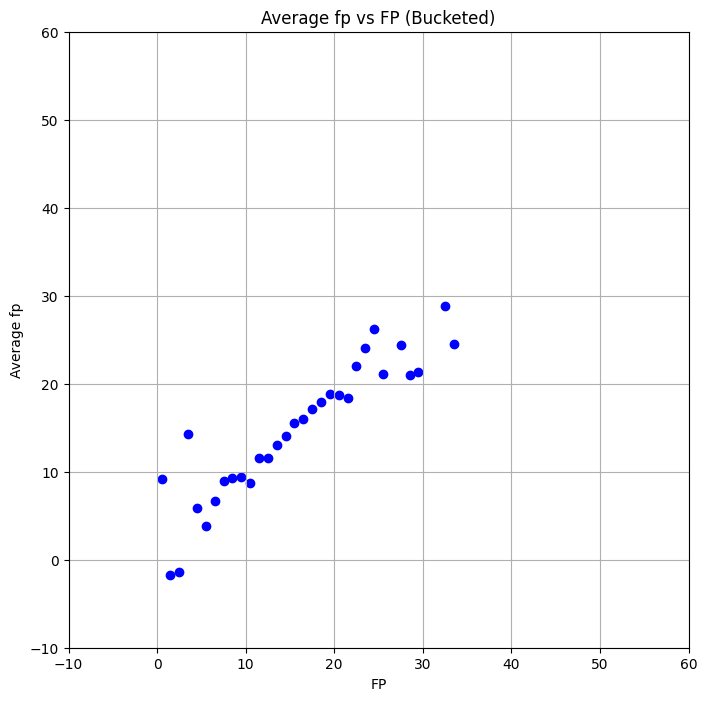

In [49]:
import numpy as np

df = pitchers_with_dff.query('starter == 1').dropna()

# Bucketing the data based on intervals of 0.5 for FP
bucket_size = 1
FP_bucketed = np.floor(df['FP'] / bucket_size) * bucket_size

# Calculating the average fp for each bucket
grouped_data = df.groupby(FP_bucketed)['fp'].mean()

# Getting the center of each bucket
bucket_centers = (grouped_data.index + bucket_size / 2)

# Creating scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(bucket_centers, grouped_data, color='blue')
plt.title('Average fp vs FP (Bucketed)')
plt.xlabel('FP')
plt.ylabel('Average fp')
plt.grid(True)

# Set the same intervals on each side from -10 to 60
plt.xlim(-10, 60)
plt.ylim(-10, 60)

plt.show()


In [41]:
##### Winsorized

In [50]:
# Winsorize the DataFrame
pitchers_winsorized = pitchers_with_dff.query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
pitchers_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000
mean,14.083667,13.724398,13.604791,-0.471140,-0.087641,100.113524,95.691129,0.472418
std,3.165800,3.480892,10.064282,9.534716,9.307655,118.719965,116.734968,0.499286
min,8.684375,6.900000,-4.050000,-17.751562,-17.450000,0.416428,0.348100,0.000000
25%,11.674219,11.302000,5.975000,-7.425781,-6.840000,10.817932,9.610000,0.000000
50%,13.934375,13.700000,13.350000,-0.454688,0.050000,50.721104,46.240000,0.000000
75%,16.331250,16.300000,21.300000,6.697656,6.800000,147.148278,135.001186,1.000000
max,20.250000,19.926000,31.900000,16.445312,16.400000,419.545608,416.160000,1.000000
